In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score,accuracy_score,log_loss
from sklearn.model_selection import train_test_split,StratifiedKFold , GridSearchCV
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer ,make_column_selector
from sklearn.pipeline import Pipeline


In [2]:
hr = pd.read_csv('HR_comma_sep.csv')

In [3]:
hr

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.10,0.77,6,247,4,0,1,0,sales,low
3,0.92,0.85,5,259,5,0,1,0,sales,low
4,0.89,1.00,5,224,5,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14990,0.40,0.57,2,151,3,0,1,0,support,low
14991,0.37,0.48,2,160,3,0,1,0,support,low
14992,0.37,0.53,2,143,3,0,1,0,support,low
14993,0.11,0.96,6,280,4,0,1,0,support,low


In [4]:
X = hr.drop('left',axis=1)
y = hr['left']

In [5]:
X_train , X_test , y_train , y_test = train_test_split(X,y,random_state=24,test_size=0.3)

In [6]:
ohe = OneHotEncoder(handle_unknown = 'ignore')
ct = make_column_transformer((ohe,make_column_selector(dtype_include=object)) ,
                                   ('passthrough',make_column_selector(dtype_exclude=object)),
                                   verbose_feature_names_out=False)
dtc = DecisionTreeClassifier(random_state=24)
pipe = Pipeline([('CT',ct),('DT',dtc)])

In [7]:
params = {'DT__min_samples_split':[2,10,25,10],
         'DT__min_samples_leaf':[1,10,25,50],
         'DT__max_depth':[None,4,6]}
kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=24)
gcv = GridSearchCV(pipe,param_grid=params,cv=kfold,scoring='roc_auc',verbose=3)
gcv.fit(X,y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END DT__max_depth=None, DT__min_samples_leaf=1, DT__min_samples_split=2;, score=0.976 total time=   0.0s
[CV 2/5] END DT__max_depth=None, DT__min_samples_leaf=1, DT__min_samples_split=2;, score=0.969 total time=   0.0s
[CV 3/5] END DT__max_depth=None, DT__min_samples_leaf=1, DT__min_samples_split=2;, score=0.971 total time=   0.0s
[CV 4/5] END DT__max_depth=None, DT__min_samples_leaf=1, DT__min_samples_split=2;, score=0.979 total time=   0.0s
[CV 5/5] END DT__max_depth=None, DT__min_samples_leaf=1, DT__min_samples_split=2;, score=0.977 total time=   0.0s
[CV 1/5] END DT__max_depth=None, DT__min_samples_leaf=1, DT__min_samples_split=10;, score=0.984 total time=   0.0s
[CV 2/5] END DT__max_depth=None, DT__min_samples_leaf=1, DT__min_samples_split=10;, score=0.979 total time=   0.0s
[CV 3/5] END DT__max_depth=None, DT__min_samples_leaf=1, DT__min_samples_split=10;, score=0.980 total time=   0.0s
[CV 4/5] END DT__max_de

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=24, shuffle=True),
             estimator=Pipeline(steps=[('CT',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000019BABC49910>),
                                                                        ('passthrough',
                                                                         'passthrough',
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000019BAA151D30>)],
                                                          verbose_feature_names_out=False)),
                                       ('DT',
                                        DecisionTreeClassifier(random_state=24))]),
             param_grid={'DT__max_depth': [None, 4, 6],
                         'DT__min_samples_leaf': [1, 10, 25, 50],
                         'DT__min_samples_split': [2, 10, 25, 10]},
             scoring='roc_auc', verbose=3)

In [8]:
print(gcv.best_params_)
print(gcv.best_score_)

{'DT__max_depth': None, 'DT__min_samples_leaf': 10, 'DT__min_samples_split': 2}
0.9858468901146015


### Best tree

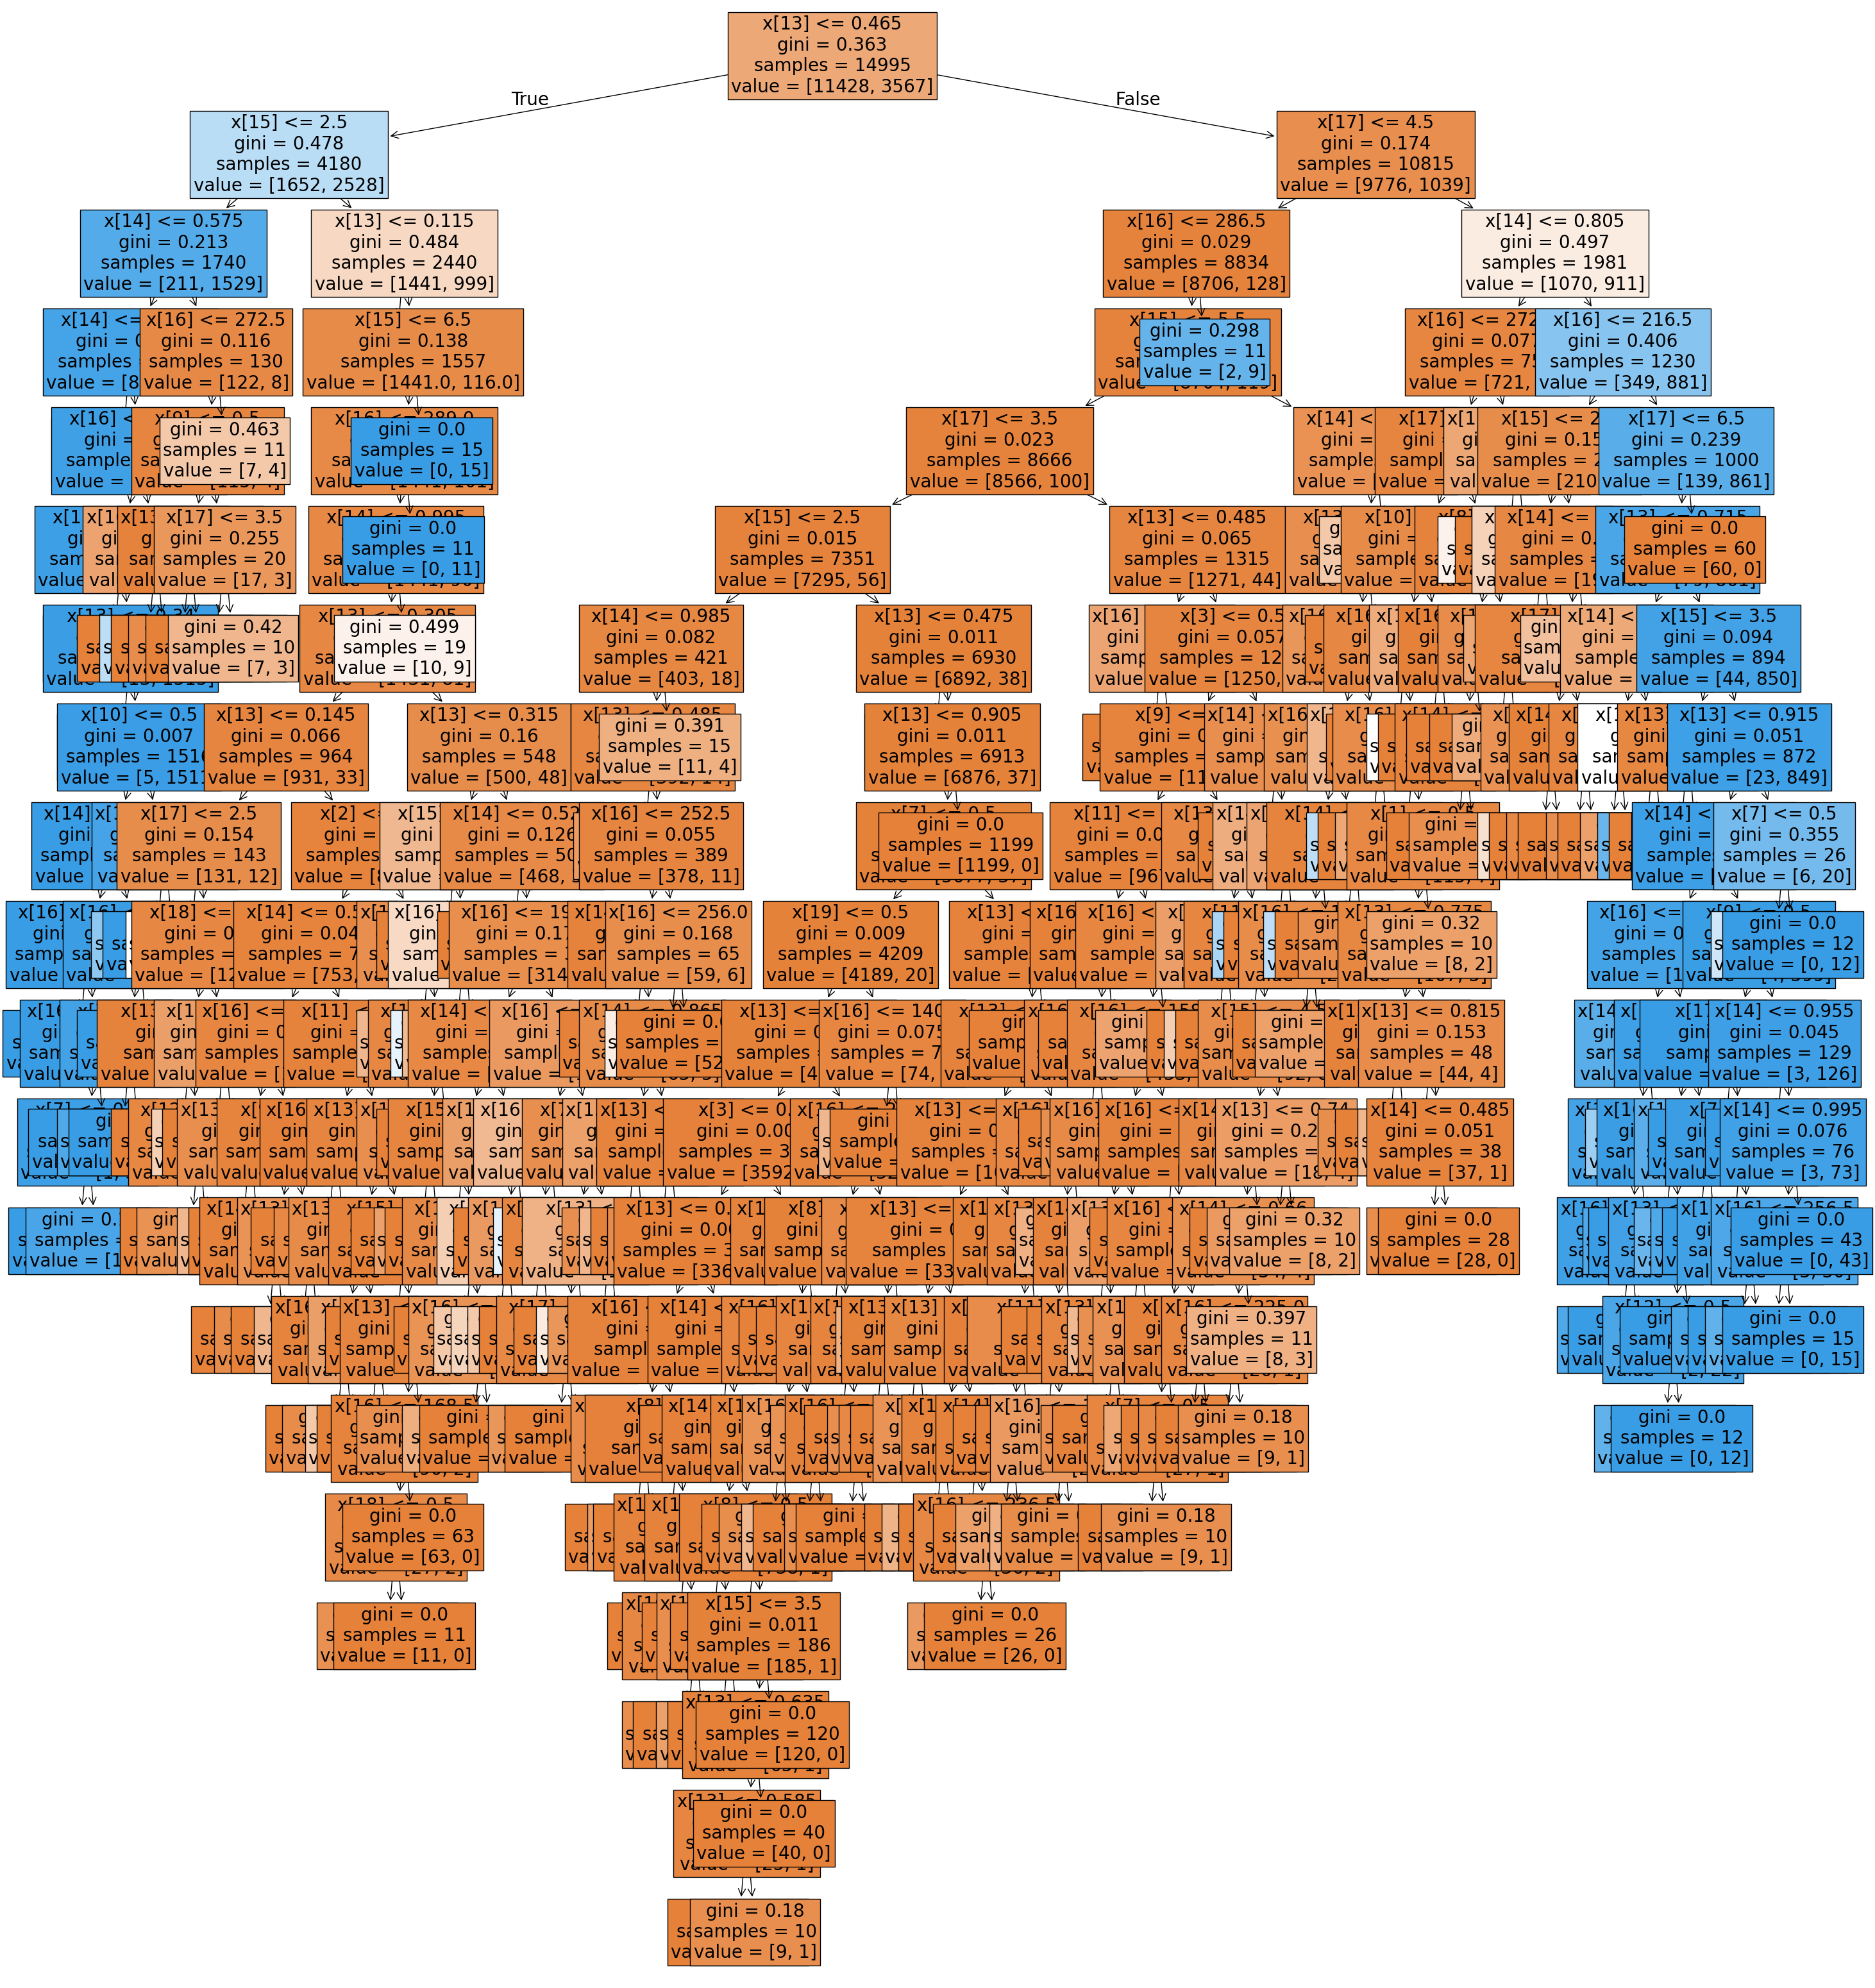

In [9]:
best_tree = gcv.best_estimator_.named_steps['DT']
plt.figure(figsize=(35,40))
plot_tree(best_tree,filled=True,fontsize=20)
plt.show()

In [10]:
gcv.best_estimator_.named_steps['CT'].get_feature_names_out()

array(['Department_IT', 'Department_RandD', 'Department_accounting',
       'Department_hr', 'Department_management', 'Department_marketing',
       'Department_product_mng', 'Department_sales', 'Department_support',
       'Department_technical', 'salary_high', 'salary_low',
       'salary_medium', 'satisfaction_level', 'last_evaluation',
       'number_project', 'average_montly_hours', 'time_spend_company',
       'Work_accident', 'promotion_last_5years'], dtype=object)

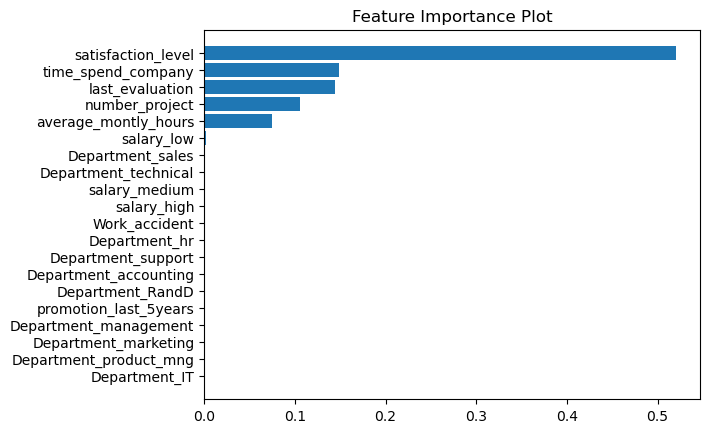

In [11]:
df_imp = pd.DataFrame({'feature':gcv.best_estimator_.named_steps['CT'].get_feature_names_out(),
                       'importance':best_tree.feature_importances_})
df_imp.sort_values('importance',inplace=True)
plt.barh(df_imp['feature'],df_imp['importance'])
plt.title('Feature Importance Plot')
plt.show()

In [12]:
best_model = gcv.best_estimator_
best_model.named_steps['DT'].feature_importances_

array([0.00000000e+00, 8.82436896e-05, 1.10125638e-04, 1.74626648e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00959036e-03,
       1.22348190e-04, 6.17931672e-04, 3.96465572e-04, 1.56364794e-03,
       6.00757834e-04, 5.20795058e-01, 1.44647015e-01, 1.05952590e-01,
       7.49001768e-02, 1.48700196e-01, 2.84670564e-04, 3.65562086e-05])

In [13]:
best_model.named_steps['CT'].get_feature_names_out()

array(['Department_IT', 'Department_RandD', 'Department_accounting',
       'Department_hr', 'Department_management', 'Department_marketing',
       'Department_product_mng', 'Department_sales', 'Department_support',
       'Department_technical', 'salary_high', 'salary_low',
       'salary_medium', 'satisfaction_level', 'last_evaluation',
       'number_project', 'average_montly_hours', 'time_spend_company',
       'Work_accident', 'promotion_last_5years'], dtype=object)